<p>  Introduces the **PyNetwork** class used to set up and run simulations <p>
<p> An instance of this **PyNetwork** class is a conceptual representation of a water distribution network. To create an instance of this class, you will use two files to specify parameters:</p>
<ol>
<li>the *.inp* file--specifies network connectivity, can be generated by EPANET</li>
<li>the *.config* file--specifies runtime parameters like number of grid cells, boundary values, simulation time, and number of time steps</li>
</ol>
Below you will see how to start with an EPANET-generated .inp file, use script to generate compatible .inp and .config files, and examine the network you've created. Then you'll learn how to specify your own network and runtime parameters, create new .inp and config files, and run a simulation.

<p> You need to specify network connectivity externally from a .inp file (I suggest generating with EPANET. If the formatting is different from that of EPANET, the file may not be read properly. All other parameters--pipe length, diameter, manning coefficient, elevation, etc can be specified from python notebook and used to write new files to run simulations.<p>
<p> In general, before you begin: <p>
<ol>
<li> Export network *mynetwork.inp* from EPANET. **Create this file with flow units of "GPM", with pipe lengths specified in feet, diameters in inches, and roughness coefficient for Hazen-Williams** Step 2. converts units to metric.</li>
<li> Use *cleanupinpfiles.py* to generate new files *mynetwork2.0.inp* and *mynetwork2.0.config* with the correct units and labeling scheme for pipes and junctions. You can do this by running the command  </li>
</ol>
<p> python cleanupinpfiles.py mynetwork.inp <p>
in a terminal in the folder where you have created myfile.

<p> **Double check** that lengths, diameters, elevations etc in mynetwork2.0.inp have correct units (should be meters for lengths, and a manning coefficient for roughness)<p>
<p>Now follow steps below to change parameters and set up your own simulation.</p>



The cell below loads modules you will need for creating networks, solving, plotting, etc.

In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
from writeit import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Now we're going to create a network based on the files we just generated using *cleanupinpfile.py*

In [2]:
fi = "../indata/check2.inp"
fc = "../indata/check2.config"
mtype  =1 #this specifies Preissman slot model; 
"""
# By Shafi
#0 indicate open channel condition
#Question: does 1 means in both open chanel , trasistion and pressurized system?- """
n0 = PyNetwork(fi,fc,mtype) # an instance of the network class

Now let's look at what we've created. A network object consists of "edges" (pipes), "nodes" (junctions), runtime info, and various methods.

In [ ]:
#"print" shows the memory address and the number of nodes and edge
print n0

In [8]:
#showLayout() shows the connectivity--how the nodes and edges are connected 
n0.showLayout()
#you can also plot the network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)

   pipe | start node | end node
-----------------------------------
     0  |  0         | 1
     1  |  1         | 2
     2  |  2         | 3
     3  |  2         | 4
     4  |  4         | 5
     5  |  5         | 6
     6  |  5         | 7
     7  |  7         | 8


   node | #incoming pipes
-------------------------
  0     |  1
  1     |  2
  2     |  3
  3     |  1
  4     |  2
  5     |  3
  6     |  1
  7     |  2
  8     |  1


<IPython.core.display.Javascript object>

The edges have the following attributes:
    <ul>
    <li>length L(m)</li>
    <li>diameter D (m) </li>
    <li>roughness Mr (Manning coefficient) </li>
    <li>number of grid cells for finite volume solver </li>
    <li>initial water height, h0 </li>
    <li> initial discharge, Q0</li>
    </ul>
  This information is stored in vectors in the network class instance. For example, n0.Ls is the vector [L0,L1,...]
  where L0 is the length of pipe 0, L1 is the length of pipe 1, etc.
  Let's take a look at these in our network:

In [ ]:
#print network parameters--these cannot be changed once the network is instantiated
# N is number dx -shafi
print "pipe   L      D      Mr     #grid cells"
for k in range(n0.Nedges):
    print "%d      %.2f  %.2f   %.3f  %d"%(k, n0.Ls[k], n0.Ds[k],n0.Mrs[k], n0.Ns[k])

In [ ]:
#print pipe initial conditions--these can be modified using setIC
#n0.showCurrentData()

Now look at junction information  

In [ ]:
#look at specification for boundary value types for junction1s--these cannot be changed once network is instantiated
n0.showExternalBoundaries()

Now let's check out the runtime parameters--these cannot be changed once network is instantiated

In [ ]:
print "Simulation run time is %.2f s, number of time steps is %d, and pressure wavespeed is %.2f m/s"%(n0.T, n0.M, n0.a[0])

Now we're going to modify initial conditions and run a simulation

1
2
3


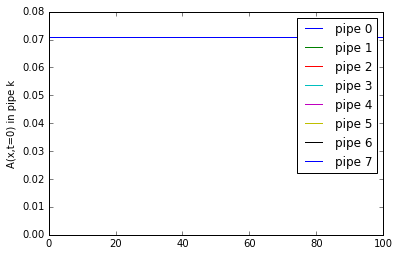

In [3]:
x = np.linspace(0,n0.Ls[0],n0.Ns[0])# make a vector with as many entries as grid cells in pipe 0
Af =(n0.Ds[0]**2)*pi/4 #full cross sectional area in pipe 0
A0 = []#we're going to store a list of these initial conditions to compare with final results later
Q0 = []
p0 = PyPipe_ps(n0.Ns[0], n0.Ds[0], n0.Ls[0], n0.M, n0.a[0])
Af =(n0.Ds[0]**2)*pi/4
h0 = p0.AofH(2,True)
q = Af*2
#assume pipes are 5% full with moving water
# reflective boundary is like we've closed valves at all exit points at time t=0
A0.append(h0*np.ones(n0.Ns[0]))
Q0.append(q*np.ones(n0.Ns[0]))
plot(x,A0[0],label='pipe 0')
n0.setIC(0,A0[0],Q0[0])  #set the initial conditions in pipe 0
#now make other pipes 'empty' (very small cross sectional area, 0 discharge)
for k in range(1,8): #len(no.Ns)
    Af =(n0.Ds[k]**2)*pi/4
    x = np.linspace(0,n0.Ls[k],n0.Ns[k])
    A0.append(.0*Af*np.ones(n0.Ns[k]))
    Q0.append(0.0*np.ones(n0.Ns[k]))
    plot(x,A0[k],label='pipe %d'%k)
    n0.setIC(k,A0[k],Q0[k])
inflow = q* np.ones(n0.M+1)
n0.setbVal(0,inflow)
ylabel('A(x,t=0) in pipe k')
legend()
#and we'll plot these initial cross-sectional areas
jt = n0.nodeTypes
aa=arange(0,len(jt)) 
for j in range(1,len(aa[n0.nodeTypes==1])):#find the junction1s and set boundary value time series to .1*(pipe diameter)
    print j
    bvt = n0.Ds[2]*np.ones(n0.M+1)
    n0.setbVal(j,bvt)
n0.setbVal(3,n0.Ds[0]*np.ones(n0.M+1))

In [4]:
#now run a simulation, keeping track of solve time and the initial and final volume of water in the network
#the simulation is run up to time T using the method runForwardProblem(dt)

import time
V0 = n0.getTotalVolume()
dt = n0.T/float(n0.M)
dx = n0.Ls/[float(nn) for nn in n0.Ns]
t0 = time.clock()
n0.runForwardProblem(dt)
tf = time.clock()
Vf = n0.getTotalVolume()
print "Solve time is %.5f s"%(tf-t0)
print "Simulated time is %.5f s"%n0.T
print "change in volume is %e m^3"%(Vf-V0)


print n0

Solve time is 131.67062 s
Simulated time is 800.00000 s
change in volume is 3.908263e+01 m^3
Network at address 0x11bfe50 with 9 nodes and 8 edges



dashed line denotes pipe crown


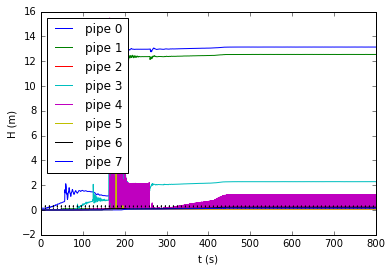

In [5]:
t = linspace(0,n0.T, n0.M+1)
for k in range(n0.Nedges):
    if k == 0:
        K = n0.Ns[k]-1 #index of cell we want to look at
    else: 
        K = n0.Ns[k]-1
    Ht = n0.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
    #fig = plt.figure(figsize= (10,5))
    plot(t,Ht, label = 'pipe %d'%k)
    plot(t,n0.Ds[k]*np.ones(len(t)),'k:')
legend(loc = 'upper left')
xlabel('t (s)')
ylabel('H (m)')
print 'dashed line denotes pipe crown'

Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


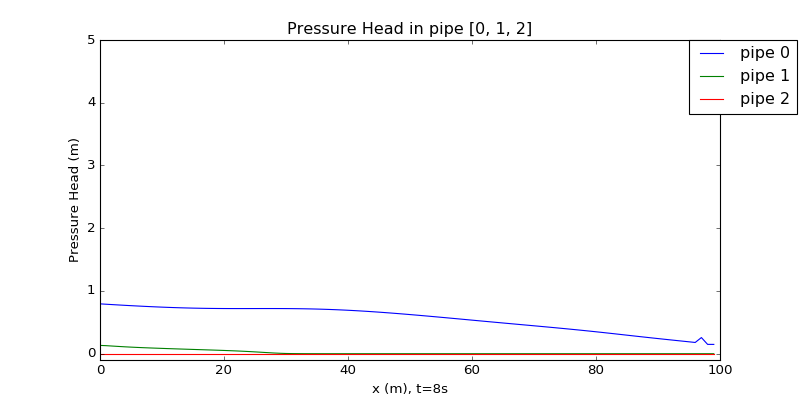

In [6]:
from __future__ import division
import sys
sys.path.append("..")    
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
#%pylab inline
%pylab notebook
from writeit import *
import pickle
import time

#*********************************************************************************
pipe_interest=[0,1,2]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=400               # unit: s
#*********************************************************************************

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(0,n0.Ls[j]-1,n0.Ns[j])
    x_interest.append(x)

#create initial figure
from matplotlib import animation
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 5)
lines = [plt.plot([], [],label='pipe {}'.format(pipe_interest[i]))[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)

def animate(index): 
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n0.pressureSpaceSeries(j,M_start+index*Mi_draw)  
        #this returns H as a function of x in pipe j at time step m
        line.set_data(x_interest[i],Hx)
        plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
        #line.set_label('pipe %d t=%.2f s'%(j,(dt*(M_start+index*Mi_draw))))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=100, blit=True)
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
print x_interest[1]
print len(x_interest[1])
print n0.pressureSpaceSeries(1,60000)
print len(n0.pressureSpaceSeries(1,60000))
qh = n0.qhist(1)
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)
N = n0.Ns[1]
print qh[idx_t(0,int(N),60000,N)]
"""

N = n1.Ns[j]
qh = n1.qhist(j) 
Ak=qh[idx_t(0,k,m,N)] "m is time step,k is grid number"
AN=qh[idx_t(1,N,1,N)]
"""

<IPython.core.display.Javascript object>


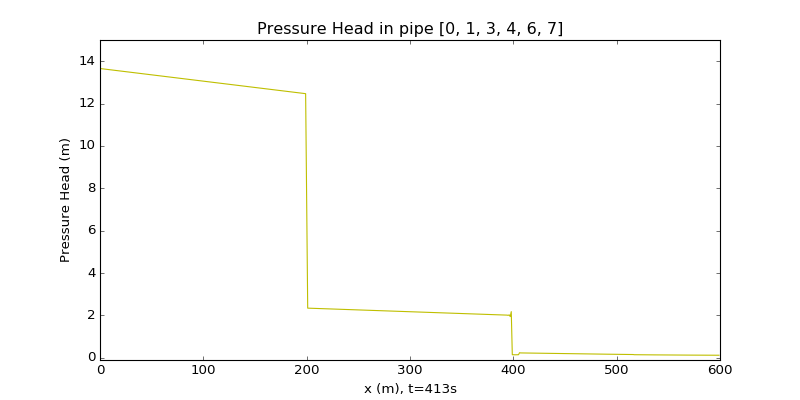

In [7]:
#*********************************************************************************
pipe_interest=[0,1,3,4,6,7]
t_delta=1              # unit: s
t_start=0               # unit:s
t_end=800               # unit: s
#*********************************************************************************

# animation already imported above
plt.ion()
plt.show()

# create x axis
x_interest=[]
pipe_length=0
for j in pipe_interest: 
    x = np.linspace(pipe_length+1,pipe_length+n0.Ls[j]-1,n0.Ns[j]-1)
    x_interest.append(x)
    pipe_length=pipe_length+n0.Ls[j]
x_interest_combine = np.concatenate(x_interest,axis =0)

#create initial figure
fig = plt.figure(figsize= (10,5))
plt.xlim(0,x_interest[-1][-1]+1)
plt.ylim(-0.1, 15)
lines = [plt.plot([], [])[0] for i in range(len(pipe_interest))] # number of lines plot on the figure
plt.xlabel('x (m)')        
plt.ylabel('Pressure Head (m)')
plt.title('Pressure Head in pipe %s'%str(pipe_interest)) 
# initialization function: plot the background of each frame

def init():
    for line in lines:
        line.set_data([], [])
    return lines

Mi_draw=int(t_delta/dt)   # difne how many steps to skip
M_start=int(t_start/dt)
M_total=int(t_end/dt)
H_interest=[]

def animate(index):
    H_interest_tfixed = []
    for i,line in enumerate(lines):             
        j=pipe_interest[i]
        Hx = n0.pressureSpaceSeries(j,M_start+index*Mi_draw)[1:]
        #this returns H as a function of x in pipe j at time step m
        H_interest_tfixed.append(Hx)
    H_interest.append(H_interest_tfixed)
    H_interest_combine = np.concatenate(H_interest[index],axis =0)
    line.set_data(x_interest_combine,H_interest_combine)
    plt.xlabel('x (m), t=%ds'%((M_start+index*Mi_draw)*dt))
                      
    return lines         
    #legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

step = int((M_total-M_start)/Mi_draw)
anim = animation.FuncAnimation(fig, animate, init_func=init,frames=step, interval=2, blit=True)
plt.show()
#anim.save('/home/xin/pipes/examples/output_data/T_junction_detection/Taddconti-pipe %s %.0f-%.0f s.mp4'%(str(pipe_interest),t_start,t_end))


#anim = animation.FuncAnimation(fig, animate, init_func=init,frames=3, interval=20, blit=True)
#anim.save("basic_animation.mp4")
#plt.show()
    # time.sleep(0.01)
    # bbox_to_anchor: the bbox that the legend will be anchored, 1.05 means 1.05 times of figure length
    # borderaxespad: the pad between the axes and legend border
    # optional:legend(loc = 'upper left')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()


<p>**IMPORTANT:** once you instantiate a network, you can only run the method *runForwardProblem(dt)* **ONCE** 
           because only enough memory is allocated to store a single run of M time steps. If you want to re-run a simulation, you need to either </p>
<ol>
 <li> re-instantiate the network using n0 = PyNetwork(fi,fc,mtype) to create a new network and start at time T=0, OR</li>
 <li> first run n0.reset(), which will allow you to run the simulation another T seconds starting with the last state at t=T
     see how to use this in *Intro_simulation_Alameda.ipynb*</li>
     
<p> For now we're just going to look at the data from this run using several attributes of the PyNetwork class.</p>

In [ ]:
#The PyNetwork function q(k) returns a list [A,Q] of the current data in pipe k
#Below we use this to retrieve and plot the final cross sectional area
# along length of each pipe and compare with our initial conditions
fig, ax1=  plt.subplots(figsize=(15,10), nrows = n0.Nedges)
fig, ax2=  plt.subplots(figsize=(15,10), nrows = n0.Nedges)
for k in range(n0.Nedges):
    N =n0.Ns[k] # Length of each pipe in integer upper
    x = linspace(0,n0.Ls[k], N)# n0.Ls>>>>real length, genarate N number bet 0 and total length
    q = n0.q(k)#this is the current data (A,Q)
    A = q[0:N]#first N entries are values of A in each cell)
    Q = q[N:]#next N entries are values of Q in each cell
    

    ax1[k].plot(x,A0[k],'g',label='pipe %d initial'%k)#we stored this above
    ax1[k].plot(x,A,'k',label='pipe %d final'%k)
    ax1[k].legend()
    ax1[k].set_ylabel('A(x)')
    ax1[k].set_xlabel('x')
  
    ax2[k].plot(x,Q0[k],'g',label='pipe %d initial'%k)#we stored this above
    ax2[k].plot(x,Q,'k',label='pipe %d final'%k)
    ax2[k].set_ylabel('Q(x)')
    ax2[k].set_xlabel('x')
    ax2[k].legend()
#print A0


<p>The vector of the entire history of (A,Q) at each time step is stored 
      and can be accessed using the PyNetwork function q_hist(i)</p>
<p>However, this requires some slightly complicated indexing (see water_hammer.ipynb for an example)</p>
<p>Below we use two shortcut functions to look at pressure head $H = \bar{p}/(\rho g)$ as a function of space and time in each pipe.</p>

In [ ]:
#first look at a time series of pressure data near the end of each pipe
t = linspace(0,n0.T, n0.M+1)
for k in range(n0.Nedges):
    K = n0.Ns[k]-2 #index of cell we want to look at
    Ht = n0.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
    plot(t,Ht, label = 'pipe %d'%k)
    plot(t,n0.Ds[k]*np.ones(len(t)),'k:')
legend(loc = 'upper left')
xlabel('t (s)')
ylabel('H (m)')
print 'dashed line denotes pipe crown'

In [ ]:
#now look at pressure head H as a function of x in pipe 2 at time step m, for m = 0,100, ...M
# import a nice colormap to do this
from matplotlib import cm
import matplotlib.colors as colors
cNorm  = colors.Normalize(vmin=0, vmax=n0.M)
sMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('Blues') )
figure(figsize(10,6))
for m in range(0,n0.M,100):
    Hx = n0.pressureSpaceSeries(2,m)#this returns H as a function of x in pipe 2 at time step m
    x = np.linspace(0,n0.Ls[2],n0.Ns[2])
    plot(x,Hx, lw = 2, color = sMap.to_rgba(m), label = 't=%.2f'%(dt*m))
xlabel('x (m)')
ylabel('H (m) in pipe 2')
xlim(0,n0.Ls[2])
legend(loc = 'upper left')

Ok, we've now seen how to instantiate a network class, look at some attributes, run a simulation, and extract the data. However, it is possible (likely!) that you will want to change runtime parameters like the simulation time, the boundary condition type, the boundary values, and more. Below we will use *writeit.py* to create new .inp and .config files with desired parameters. Then we can instantiate another network and run it!

In [ ]:
Np = n0.Nedges #number of pipes
T = 20 #run time in seconds
a = 150 #pressure wave speed in m/s (this sets the Preissman slot width)

#pipe stuff
Ls = [100,50,25] #try new pipe lengths
Ns = [int(l) for l in Ls]   # set dx = 1 meter by assigning 1 grid cell per meter of length
Ds = [0.1,0.05,0.05]  #try new pipe diameters
Mrs = n0.Mrs  #keep Manning coeff the same
h0s = [5,5,5] #constant initial value of water height (if you want nonconstant, specify later with setIC)
q0s = [0.007, 0.007,0.007] #constant initial discharge Q (if you want nonconstant, specify later with setIC)

#runtime stuff
dx = [Ls[i]/Ns[i] for i in range(Np)]  
M = int(T*a/(max(dx)*.8))#set time steps based on dx to assure CFL condition (may need to adjust up if slopes are steep)

#junction stuff
elevs = [0,0,0,0] #make it flat this time
jt = n0.nodeTypes #junction type (can also write this out as a list--in this case, [1,3,1,1]
# note that below, r, bt, and bval only matter for the nodes with one incoming pipe--nodes 0,1 and 2
r  = [0,0,1,0] #reflection: we're doing specified bounary at nodes 0 and 3, reflection at node 2
bt = [1,0,0,2] #boundary type (only matters if r=0). Here we're specifying Q at node 0 and orifice outflow at node 2
bv = [0.007,0,0,n0.Ds[2]/2] #node 0: Q = 0.007; node 3: orifice opening height =D/2



In [ ]:
#specify .inp file with network connectivity
oldinp = "../indata/mynetwork2.0.inp"
#new prefix for .inp and .config files that will be used for actual runtime parameters
fn = "../indata/myfile_new"
#and write the files!
(fi2, fc2) = rewritePipes(fn,oldinp, Ns, Ls, Mrs, Ds, jt, bt, bv, r, h0s, q0s, T, M, a, elevs)

In [ ]:
print "name of new files is %s and %s "%(fi2, fc2)

In [ ]:
# now make a new network
n1 = PyNetwork(fi2,fc2,mtype)

In [ ]:
n1.showExternalBoundaries()
T = n1.T
M = n1.M
dt = T/float(M)

In [ ]:

V0 = n1.getTotalVolume()
t0 = time.clock()
n1.runForwardProblem(dt)
tf = time.clock()
Vf = n1.getTotalVolume()
print "Solve time is %.5f s"%(tf-t0)
print "Simulated time is %.5f s"%n0.T
print "change in volume is %e m^3"%(Vf-V0)
print "note we don't expect volume to be constant since we have orifice and outflow boundaries"

In [ ]:
t = linspace(0,n1.T, n1.M+1)
for k in range(0,n1.Nedges):
    K = n1.Ns[k]/2 #index of cell we want to look at (midway in each pipe)
    Ht = n1.pressureTimeSeries(k,K)#this function returns H in cell K of pipe k, at each time step
    plot(t,Ht, label = 'pipe %d'%k)
    plot(t,n1.Ds[k]*np.ones(len(t)),'k:')
legend(loc = 'lower right')
xlabel('t (s)')
ylabel('H (m)')
print 'dashed line denotes pipe crown'

Parting thoughts: what to try if your simulation isn't working (a partial list)
<ul>
<li>Try using a smaller time step</li>
<li> Check your .inp and .config files to make sure that your network connectivity and parameters are what you think they are</li>
<li>Check that your initial and boundary conditions are what they think they are</li>
<li> Watch out for totally empty pipes! I usually use $\epsilon A_f$ where $\epsilon$ is 0.01 or 0.001, as an initial condition in an 'empty' pipe. This avoids tricky things happening with near-zero cross sectional areas.</li>
<li>Watch out for $A$ specified on boundary--this can be finicky if you have a big jump from the boundary value to the interior value of the pipe. Try introducing a transition pipe with the same value of $A$ throughout that connects to the first pipe in your network </li>
<li>Try doing a shorter or smaller simulation</li>
<li>Check that you haven't accidentally zeroed something out through Python integer division. Remember! 2/5 = 0, but 2./5. = 0.4</li>
<li> ...and many other things! </li>
</ul>